In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    ResNet50, 
    InceptionResNetV2, 
    Xception, 
    InceptionV3, 
    VGG16
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\adity\OneDrive\Documents\College\Minor Project\Code\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\adity\OneDrive\Documents\College\Minor Project\Code\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\adity\OneDrive\Documents\College\Minor Project\Code\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 

In [2]:
# ===== CONFIG =====
DATA_DIR = "./data_cxr/covid_qu_ex_masked"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEAD = 10        # Epochs for training the new layers
EPOCHS_FINETUNE = 15    # Epochs for fine-tuning the whole model
LR_HEAD = 1e-4          # Higher LR fpr tje head
LR_FINETUNE = 5e-6      # Lower since we're fine-tuning

MODEL_NAME = "ResNet50"  # Change to: "InceptionResNetV2", "Xception", "InceptionV3", "VGG16"

In [3]:
# ===== DATA GENERATORS =====
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
test_gen = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 3728 images belonging to 3 classes.
Found 932 images belonging to 3 classes.
Found 1166 images belonging to 3 classes.


In [4]:
# Check training data
train_class_labels = list(train_gen.class_indices.keys())
train_counts = np.unique(train_gen.classes, return_counts=True)[1]
print("Training data distribution:", dict(zip(train_class_labels, train_counts)))

# Check validation data
val_class_labels = list(val_gen.class_indices.keys())
val_counts = np.unique(val_gen.classes, return_counts=True)[1]
print("Validation data distribution:", dict(zip(val_class_labels, val_counts)))

Training data distribution: {'COVID-19': np.int64(1864), 'Non-COVID': np.int64(932), 'Normal': np.int64(932)}
Validation data distribution: {'COVID-19': np.int64(466), 'Non-COVID': np.int64(233), 'Normal': np.int64(233)}


In [5]:
from sklearn.utils import class_weight

# Calculate the weights based on the training data
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

# Keras expects a dictionary mapping class indices to weights
class_weights_dict = dict(enumerate(class_weights))

In [6]:
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(0.6666666666666666), 1: np.float64(1.3333333333333333), 2: np.float64(1.3333333333333333)}


In [7]:
# ===== MODEL LOADER =====
def load_base_model(name):
    input_shape = IMG_SIZE + (3,)
    if name == "ResNet50":
        return ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    elif name == "InceptionResNetV2":
        return InceptionResNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
    elif name == "Xception":
        return Xception(weights="imagenet", include_top=False, input_shape=input_shape)
    elif name == "InceptionV3":
        return InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
    elif name == "VGG16":
        return VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unknown model name: {name}")

base_model = load_base_model(MODEL_NAME)
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=LR_HEAD),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# ===== STAGE 1: TRAIN THE HEAD ===== 

# Add callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# This will reduce the learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,             # Reduce LR by half
    patience=2,             # Number of epochs to wait for improvement
    min_lr=1e-7,            # Don't let the LR get too small
    verbose=1
)

checkpoint_callback = ModelCheckpoint(
    "best" + MODEL_NAME + ".keras",       # Filepath to save the model
    monitor='val_accuracy',               # Metric to monitor
    save_best_only=True,                  # Only save the best model
    mode='max',                           # We want to maximize accuracy
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,                 # Stop after 5 epochs with no improvement
    restore_best_weights=True   # Restore weights from the best epoch
)

history_head = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_HEAD,
    callbacks=[checkpoint_callback, early_stopping_callback, lr_scheduler],
    class_weight= class_weights_dict
)

c:\Users\adity\OneDrive\Documents\College\Minor Project\Code\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.3440 - loss: 1.2954
Epoch 1: val_accuracy improved from None to 0.37661, saving model to bestResNet50.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.3388 - loss: 1.2654 - val_accuracy: 0.3766 - val_loss: 1.0755 - learning_rate: 1.0000e-04
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.3410 - loss: 1.2033
Epoch 2: val_accuracy improved from 0.37661 to 0.53648, saving model to bestResNet50.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.3527 - loss: 1.1865 - val_accuracy: 0.5365 - val_loss: 1.0282 - learning_rate: 1.0000e-04
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.4006 - loss: 1.1202
Epoch 3: val_accuracy improved from 0.53648 to 0.55365, saving model to bestResNet50.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.3954 - loss: 1.1212 - val_accuracy: 0.5536 - val_loss: 1.0284 - learning_rate: 1.0000e-04
Epoch 4/10
117/117 ━━━━━━━━━

In [10]:
# ===== STAGE 2: FINE-TUNE THE TOP LAYERS =====
print("\n--- Starting Stage 2: Fine-tuning the top layers of the model ---")

# Unfreeze the base model
base_model.trainable = True

# How many layers to unfreeze? A common practice is to fine-tune the top block.
# Let's find the right point in ResNet50. You can see all layer names by
# printing base_model.summary()
# For ResNet50, a good split point is often the start of the last convolutional block.
# Let's unfreeze from layer 143 onwards (the 'conv5_block1_out' layer)

for layer in base_model.layers[:143]:
    layer.trainable = False

# Re-compile the model with a VERY LOW learning rate
# It's crucial to create a NEW optimizer instance here.
model.compile(optimizer=Adam(learning_rate=LR_FINETUNE),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

print("Number of trainable weights after partial unfreezing:", len(model.trainable_weights))

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINETUNE,
    callbacks=[checkpoint_callback, early_stopping_callback, lr_scheduler],
    class_weight=class_weights_dict
)


--- Starting Stage 2: Fine-tuning the top layers of the model ---
Number of trainable weights after partial unfreezing: 44
Epoch 1/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5211 - loss: 1.3659
Epoch 1: val_accuracy did not improve from 0.57725
117/117 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.5531 - loss: 1.1125 - val_accuracy: 0.5000 - val_loss: 1.2605 - learning_rate: 5.0000e-06
Epoch 2/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5848 - loss: 0.8787
Epoch 2: val_accuracy improved from 0.57725 to 0.62339, saving model to bestResNet50.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.6062 - loss: 0.8620 - val_accuracy: 0.6234 - val_loss: 0.8183 - learning_rate: 5.0000e-06
Epoch 3/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6287 - loss: 0.8118
Epoch 3: val_accuracy improved from 0.62339 to 0.68026, saving model to bestResNet50.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.6360 - loss: 0.7905 - val_accuracy: 0.68

c:\Users\adity\OneDrive\Documents\College\Minor Project\Code\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 812ms/step


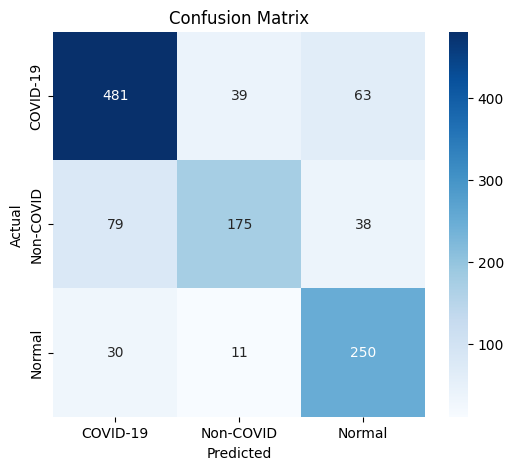

Classification Report:

              precision    recall  f1-score   support

    COVID-19       0.82      0.83      0.82       583
   Non-COVID       0.78      0.60      0.68       292
      Normal       0.71      0.86      0.78       291

    accuracy                           0.78      1166
   macro avg       0.77      0.76      0.76      1166
weighted avg       0.78      0.78      0.77      1166



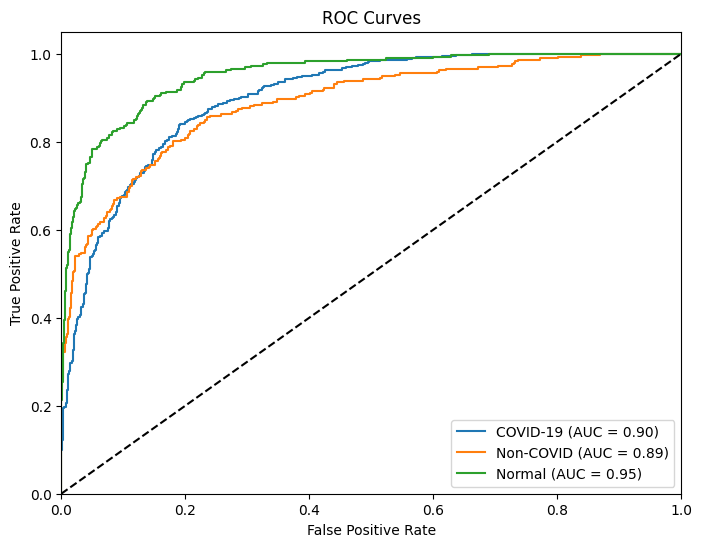

In [11]:
# ===== EVALUATE =====
# Load the best model saved by the callback for evaluation
model.load_weights("best" + MODEL_NAME + ".keras")

y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

plt.figure(figsize=(8,6))
for i, class_name in enumerate(class_labels):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.savefig("roc_curves.png")
plt.show()